In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from google.colab import files
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN

from sklearn.metrics import accuracy_score

In [ ]:
excel_file = pd.read_excel("//content/drive/MyDrive/prix_produits_agricoles_maroc_300.xlsx")
excel_file.to_csv("/content/drive/MyDrive/prix_produits_agricoles_maroc_300.csv", index=False)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/prix_produits_agricoles_maroc_300.csv")

df.dropna(inplace=True)

df["Prix (MAD/kg)"] = pd.to_numeric(df["Prix (MAD/kg)"], errors='coerce')

df.drop_duplicates(inplace=True)

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

df = df[(df["prix_(mad/kg)"] >= 2) & (df["prix_(mad/kg)"] <= 20)]

label_encoder_produit = LabelEncoder()
label_encoder_region = LabelEncoder()

df["produit"] = label_encoder_produit.fit_transform(df["produit"])
df["région"] = label_encoder_region.fit_transform(df["région"])

df["année"] = df["date"].apply(lambda x: int(x.split("-")[0]))
df["mois"] = df["date"].apply(lambda x: int(x.split("-")[1]))

df.drop(columns=["date"], inplace=True)

df.to_csv("prix_produits_agricoles_maroc_encoded.csv", index=False, encoding="utf-8")

print("✅ Fichier nettoyé et encodé enregistré avec succès !")


✅ Fichier nettoyé et encodé enregistré avec succès !


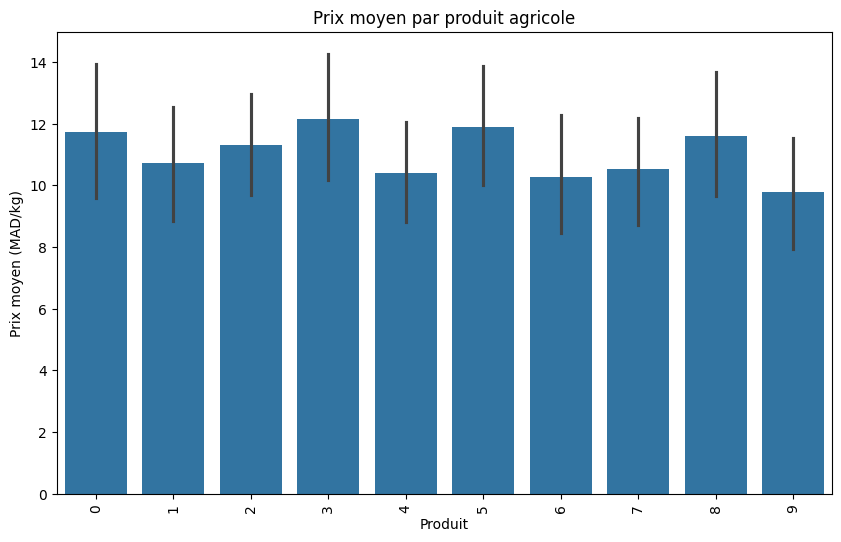

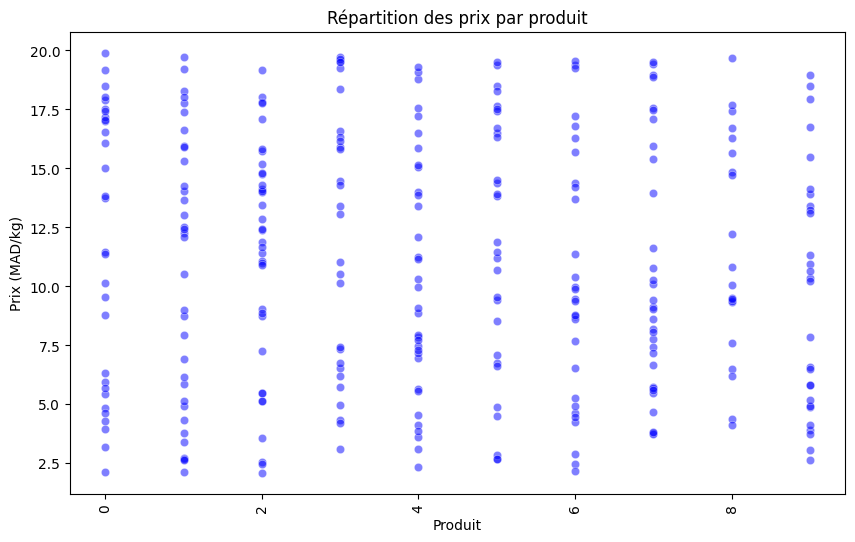

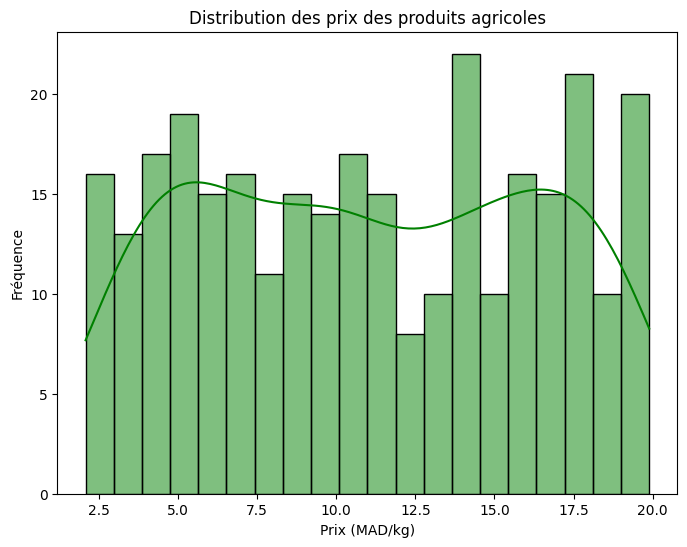

In [ ]:


plt.figure(figsize=(10, 6))
sns.barplot(x="produit", y="prix_(mad/kg)", data=df, estimator=lambda x: sum(x)/len(x))
plt.xticks(rotation=90)
plt.xlabel("Produit")
plt.ylabel("Prix moyen (MAD/kg)")
plt.title("Prix moyen par produit agricole")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="produit", y="prix_(mad/kg)", data=df, alpha=0.5, color="blue")
plt.xticks(rotation=90)
plt.xlabel("Produit")
plt.ylabel("Prix (MAD/kg)")
plt.title("Répartition des prix par produit")
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df["prix_(mad/kg)"], bins=20, kde=True, color="green")
plt.xlabel("Prix (MAD/kg)")
plt.ylabel("Fréquence")
plt.title("Distribution des prix des produits agricoles")
plt.show()


 Tableau des centres de clusters (K-Means) :
    Cluster  Centre PCA1  Centre PCA2
0        0    -0.686771     0.822782
1        1    -0.462617    -1.066752
2        2     1.169563     0.073911

 Tableau des centres de clusters (K-Means + DBSCAN) :
    Cluster  Centre PCA1  Centre PCA2
0        0    -0.671162     0.831508
1        1     1.142385     0.078436
2        2    -0.444175    -1.069921


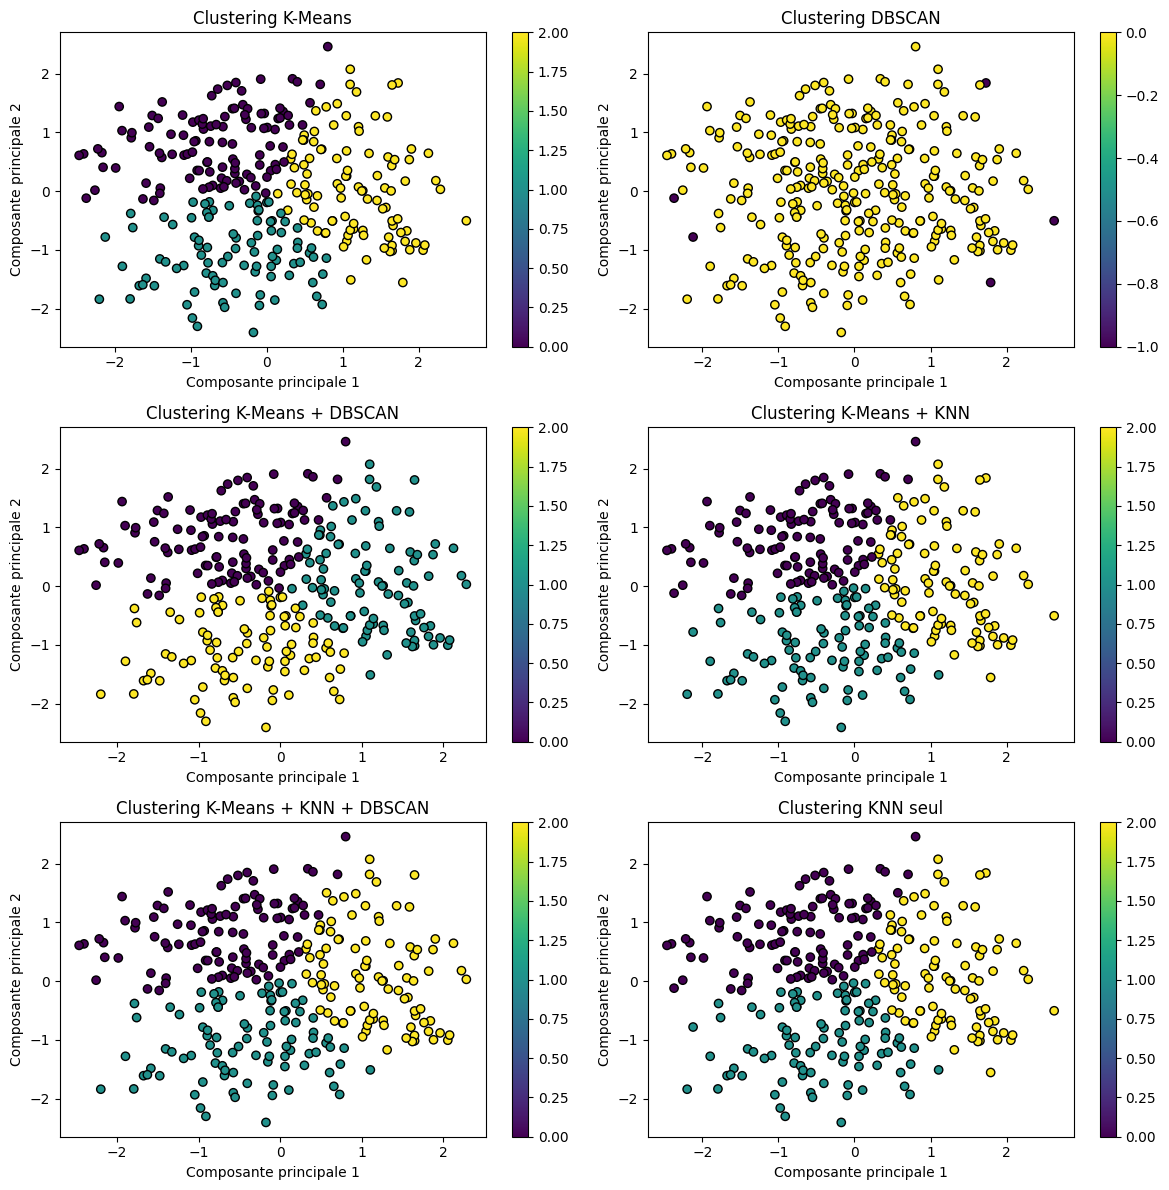

In [ ]:
df = pd.read_csv("prix_produits_agricoles_maroc_encoded.csv")
X = df.values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)


dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

filtered_data = X_pca[dbscan_labels != -1]
if len(filtered_data) > 0:
    kmeans_dbscan = KMeans(n_clusters=3, random_state=42, n_init=10)
    kmeans_dbscan_labels = kmeans_dbscan.fit_predict(filtered_data)
else:
    kmeans_dbscan_labels = []

knn_kmeans = KNeighborsClassifier(n_neighbors=5)
knn_kmeans.fit(X_pca, kmeans_labels)
knn_labels_full = knn_kmeans.predict(X_pca)

if len(filtered_data) > 0:
    knn_labels_dbscan = knn_kmeans.predict(filtered_data)
else:
    knn_labels_dbscan = []

knn_alone = KNeighborsClassifier(n_neighbors=5)
X_train, X_test, y_train, y_test = train_test_split(X_pca, kmeans_labels, test_size=0.3, random_state=42)
knn_alone.fit(X_train, y_train)
knn_labels_alone = knn_alone.predict(X_pca)

def compute_cluster_centers(X, labels, method_name):
    unique_labels = np.unique(labels)
    cluster_centers = []
    for lbl in unique_labels:
        cluster_points = X[labels == lbl]
        center = cluster_points.mean(axis=0)
        cluster_centers.append([lbl, center[0], center[1]])

    df_centers = pd.DataFrame(cluster_centers, columns=["Cluster", "Centre PCA1", "Centre PCA2"])
    print(f"\n Tableau des centres de clusters ({method_name}) :\n", df_centers)

compute_cluster_centers(X_pca, kmeans_labels, "K-Means")
if len(filtered_data) > 0:
    compute_cluster_centers(filtered_data, kmeans_dbscan_labels, "K-Means + DBSCAN")

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

def plot_clusters(ax, X, labels, title):
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel("Composante principale 1")
    ax.set_ylabel("Composante principale 2")
    fig.colorbar(scatter, ax=ax)

plot_clusters(axes[0, 0], X_pca, kmeans_labels, "Clustering K-Means")
plot_clusters(axes[0, 1], X_pca, dbscan_labels, "Clustering DBSCAN")
plot_clusters(axes[1, 0], filtered_data, kmeans_dbscan_labels, "Clustering K-Means + DBSCAN")
plot_clusters(axes[1, 1], X_pca, knn_labels_full, "Clustering K-Means + KNN")
plot_clusters(axes[2, 0], filtered_data, knn_labels_dbscan, "Clustering K-Means + KNN + DBSCAN")
plot_clusters(axes[2, 1], X_pca, knn_labels_alone, "Clustering KNN seul")

plt.tight_layout()
plt.show()


Accuracy de KNN seul : 0.99
Accuracy de DBSCAN + KNN : 0.96


<ipython-input-13-5b611cb34a20>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="viridis")


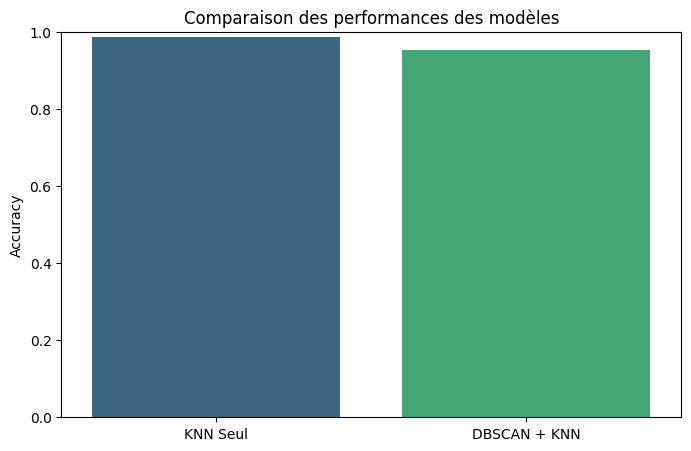

In [ ]:
df = pd.read_csv("prix_produits_agricoles_maroc_encoded.csv")
X = df.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

filtered_data = X_pca[dbscan_labels != -1]
if len(filtered_data) > 0:
    kmeans_dbscan = KMeans(n_clusters=3, random_state=42, n_init=10)
    kmeans_dbscan_labels = kmeans_dbscan.fit_predict(filtered_data)
else:
    kmeans_dbscan_labels = []

knn_kmeans = KNeighborsClassifier(n_neighbors=5)
knn_kmeans.fit(X_pca, kmeans_labels)
knn_labels_kmeans = knn_kmeans.predict(X_pca)

if len(filtered_data) > 0:
    knn_labels_dbscan = knn_kmeans.predict(filtered_data)
else:
    knn_labels_dbscan = []


knn_alone = KNeighborsClassifier(n_neighbors=5)
X_train, X_test, y_train, y_test = train_test_split(X_pca, kmeans_labels, test_size=0.3, random_state=42)
knn_alone.fit(X_train, y_train)
knn_labels_alone = knn_alone.predict(X_pca)

knn_accuracy = accuracy_score(y_test, knn_alone.predict(X_test))

if len(filtered_data) > 0:
    X_train, X_test, y_train, y_test = train_test_split(filtered_data, kmeans_dbscan_labels, test_size=0.3, random_state=42)
    knn_kmeans.fit(X_train, y_train)
    knn_dbscan_accuracy = accuracy_score(y_test, knn_kmeans.predict(X_test))
else:
    knn_dbscan_accuracy = 0

print(f"Accuracy de KNN seul : {knn_accuracy:.2f}")
print(f"Accuracy de DBSCAN + KNN : {knn_dbscan_accuracy:.2f}")


models = ['KNN Seul', 'DBSCAN + KNN']
accuracies = [knn_accuracy, knn_dbscan_accuracy]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette="viridis")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparaison des performances des modèles")
plt.show()


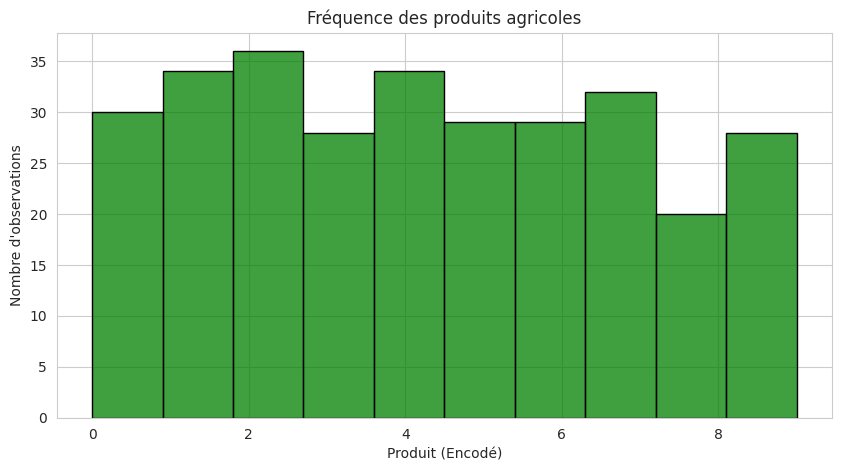

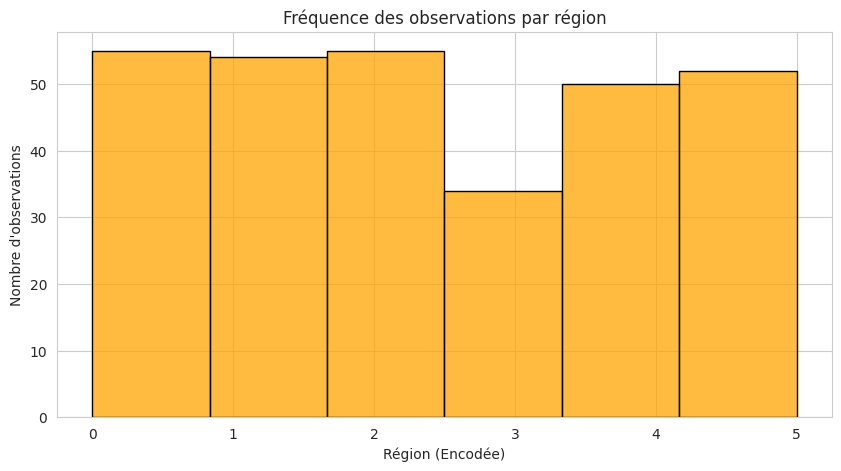

In [ ]:

df = pd.read_csv("prix_produits_agricoles_maroc_encoded.csv")

sns.set_style("whitegrid")



plt.figure(figsize=(10, 5))
sns.histplot(df["produit"], bins=len(df["produit"].unique()), color="green", edgecolor="black")
plt.title("Fréquence des produits agricoles")
plt.xlabel("Produit (Encodé)")
plt.ylabel("Nombre d'observations")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df["région"], bins=len(df["région"].unique()), color="orange", edgecolor="black")
plt.title("Fréquence des observations par région")
plt.xlabel("Région (Encodée)")
plt.ylabel("Nombre d'observations")
plt.show()


In [ ]:
pip install mlxtend


In [ ]:
df = pd.read_csv("prix_produits_agricoles_maroc_encoded.csv")

print("Aperçu des données :")
print(df.head())

df_binary = df.applymap(lambda x: 1 if x > 0 else 0)

frequent_itemsets = apriori(df_binary, min_support=0.1, use_colnames=True)

print("\nItems fréquents détectés :")
print(frequent_itemsets)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

print("\nRègles d'association trouvées :")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

rules.to_csv("regles_association.csv", index=False)
print("\nLes règles d'association ont été sauvegardées dans 'regles_association.csv'.")


Aperçu des données :
   produit  prix_(mad/kg)  région  année  mois
0        9          17.94       3   2023     9
1        3          13.41       4   2023     4
2        4          13.99       0   2023     2
3        0          19.89       0   2023     2
4        0          17.51       5   2023     8

Items fréquents détectés :
     support                                       itemsets
0   0.900000                                      (produit)
1   1.000000                                (prix_(mad/kg))
2   0.816667                                       (région)
3   1.000000                                        (année)
4   1.000000                                         (mois)
5   0.900000                       (prix_(mad/kg), produit)
6   0.746667                              (région, produit)
7   0.900000                               (produit, année)
8   0.900000                                (produit, mois)
9   0.816667                        (prix_(mad/kg), région)
10  1.000

<ipython-input-15-a446ffccf710>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_binary = df.applymap(lambda x: 1 if x > 0 else 0)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
